# 中证1000因子分析实战

本notebook详细演示因子分析的完整流程，包括：
- 数据加载与预处理
- 涨停/成交不足股票过滤
- IC（信息系数）分析
- 分层收益回测
- 结果可视化

---

## 1. 环境配置与数据加载

### 1.1 导入必要的库

In [7]:
import os
# 切换工作目录到项目根目录
os.chdir('/data1/code_git/tick_data_analysis')
import pandas as pd
import numpy as np
import sys
# 添加项目根目录到Python路径
PROJECT_ROOT = '/data1/code_git/tick_data_analysis'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import warnings
warnings.filterwarnings('ignore')

from config import tushare_tk
# 自定义模块
from mylib.get_local_data import get_local_data, list_data_files
import tushare as ts
ts.set_token(tushare_tk)
pro = ts.pro_api()
zz1000_df = df = pro.index_weight(index_code='000852.SH', start_date='20210101', end_date='20210130')
zz1000_list = zz1000_df['con_code'].tolist()
print(zz1000_df,len(zz1000_list))
print("库导入成功！")

    index_code   con_code trade_date  weight
0    000852.SH  300677.SZ   20210129   0.999
1    000852.SH  000799.SZ   20210129   0.814
2    000852.SH  300724.SZ   20210129   0.519
3    000852.SH  000733.SZ   20210129   0.456
4    000852.SH  002497.SZ   20210129   0.454
..         ...        ...        ...     ...
995  000852.SH  688108.SH   20210129   0.011
996  000852.SH  603676.SH   20210129   0.010
997  000852.SH  603815.SH   20210129   0.010
998  000852.SH  002969.SZ   20210129   0.010
999  000852.SH  300798.SZ   20210129   0.009

[1000 rows x 4 columns] 1000
库导入成功！


### 1.2 查看数据结构

首先了解数据文件的组织方式：

In [8]:
# 查看daily数据文件
files = list_data_files('daily')
print(f"daily数据文件数: {len(files)}")
print(f"前3个文件: {files[:3]}")
print(f"后3个文件: {files[-3:]}")

daily数据文件数: 1482
前3个文件: [(20200102, 'daily_data/daily/2020/01/daily_20200102.parquet'), (20200103, 'daily_data/daily/2020/01/daily_20200103.parquet'), (20200106, 'daily_data/daily/2020/01/daily_20200106.parquet')]
后3个文件: [(20260206, 'daily_data/daily/2026/02/daily_20260206.parquet'), (20260209, 'daily_data/daily/2026/02/daily_20260209.parquet'), (20260210, 'daily_data/daily/2026/02/daily_20260210.parquet')]


数据按年/月目录组织：
```
daily_data/daily/
├── 2025/
│   ├── 01/daily_20250102.parquet
│   ├── 02/daily_20250206.parquet
│   └── ...
└── 2026/
    └── ...
```

### 1.3 加载因子数据

使用`get_local_data`函数加载指定字段的数据：

In [9]:
%%time
# 加载收盘价数据
close_df = get_local_data(
    sec_list=zz1000_list,  # None表示所有股票
    start='20200101',
    end='20261031',
    filed='close',
    data_type='daily'
)

print(f"收盘价数据形状: {close_df.shape}")
print(f"交易日数: {close_df.shape[0]}")
print(f"股票数: {close_df.shape[1]}")
print(f"\n数据预览:")
print(close_df.head())
print(close_df.tail())

[优化] 读取 7 年数据 (7 个合并文件, 0 个每日文件)
收盘价数据形状: (1481, 1000)
交易日数: 1481
股票数: 1000

数据预览:
ts_code     000006.SZ  000011.SZ  000016.SZ  000019.SZ  000025.SZ  000030.SZ  \
date                                                                           
2020-01-02       5.40       9.51       4.46       6.17      21.30       4.83   
2020-01-03       5.48       9.49       4.46       6.35      21.15       4.82   
2020-01-06       5.46       9.39       4.41       6.33      21.19       4.88   
2020-01-07       5.49       9.55       4.50       6.39      21.47       4.99   
2020-01-08       5.39       9.29       4.48       6.37      21.01       5.10   

ts_code     000032.SZ  000034.SZ  000035.SZ  000036.SZ  ...  688033.SH  \
date                                                    ...              
2020-01-02      14.70      20.59       6.11       4.32  ...      27.52   
2020-01-03      14.81      20.60       6.06       4.29  ...      27.97   
2020-01-06      15.25      20.13       5.91       4.28  ... 

In [10]:
%%time
from mylib.get_local_data import get_all_data                                                                                                                                                                                      
                                                                                                                                                                                                                                    
daily_data = get_all_data(
    data_type='daily',
    start='20200101',
    end='20261212',
    sec_list = zz1000_list,
)
print(daily_data.keys())
daily_basic_data = get_all_data(data_type='daily_basic',start='20200101',end='20261212',sec_list=zz1000_list)
print(daily_basic_data.keys())

[get_all_data] daily: 7年数据, 7个full文件, 0个需合并
dict_keys(['open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount'])
[get_all_data] daily_basic: 7年数据, 7个full文件, 0个需合并
dict_keys(['close', 'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'dv_ratio', 'dv_ttm', 'total_share', 'float_share', 'free_share', 'total_mv', 'circ_mv'])
CPU times: user 5.28 s, sys: 2.27 s, total: 7.55 s
Wall time: 3.07 s


In [15]:
print(daily_basic_data['pb'])

ts_code     000006.SZ  000011.SZ  000016.SZ  000019.SZ  000025.SZ  000030.SZ  \
date                                                                           
2020-01-02     1.1415     1.7380     1.2885     1.6211     8.2401     1.3672   
2020-01-03     1.1584     1.7344     1.2885     1.6684     8.1821     1.3644   
2020-01-06     1.1542     1.7161     1.2741     1.6631     8.1975     1.3814   
2020-01-07     1.1605     1.7453     1.3001     1.6789     8.3059     1.4125   
2020-01-08     1.1394     1.6978     1.2943     1.6736     8.1279     1.4437   
...               ...        ...        ...        ...        ...        ...   
2026-02-04     2.2663     1.6068     7.2868     1.6725     4.4027     1.1439   
2026-02-05     2.2513     1.6033     6.7921     1.6633     4.3693     1.1397   
2026-02-06     2.2463     1.5910     7.0014     1.6448     4.3645     1.1375   
2026-02-09        NaN        NaN        NaN        NaN        NaN        NaN   
2026-02-10     2.3139     1.6103     7.6

In [ ]:
df_all = pd.DataFrame(daily_data['close'].stack())
df_all.columns = ['close']
df_all['money'] = daily_data['amount'].stack()
df_all['f_ret'] = (daily_data['close'].shift(-1)/ daily_data['open'].shift(-1)).stack()
df_all['f_ret_co'] = (daily_data['open'].shift(-2)/ daily_data['close'].shift(-1)).stack()
for k,v in daily_basic_data.items():
    df_all[k] = v.stack()
df_all.index.names = ['day','sec']
print(df_all)

                       close        money     f_ret  turnover_rate  \
day        sec                                                       
2020-01-02 000006.SZ    5.40    67452.865  1.014815         0.9252   
           000011.SZ    9.51    34098.873  0.997897         0.6817   
           000016.SZ    4.46   122819.660  0.997763         1.7238   
           000019.SZ    6.17    44629.575  1.025848         1.7442   
           000025.SZ   21.30   149086.870  0.996232         1.7819   
...                      ...          ...       ...            ...   
2026-02-10 688122.SH   83.68  1024137.298       NaN         1.8800   
           688139.SH   32.82    67229.586       NaN         0.6476   
           688188.SH  151.00   205804.008       NaN         0.4720   
           688366.SH   47.13    28121.145       NaN         0.3072   
           688388.SH   45.60  1619284.153       NaN         8.3923   

                      turnover_rate_f  volume_ratio        pe   pe_ttm  \
day        sec 

pb_q               0         1         2         3         4
day                                                         
2020-01-02  1.002112  1.008510  1.006573  1.003627  1.002825
2020-01-03  1.013409  1.024337  1.019912  1.017721  1.019383
2020-01-06  1.028713  1.038913  1.034406  1.032228  1.034587
2020-01-07  1.015165  1.031997  1.027737  1.021111  1.027882
2020-01-08  1.021151  1.040319  1.034721  1.031006  1.041402
...              ...       ...       ...       ...       ...
2026-02-02  4.141284  4.140580  5.000980  4.644723  7.211585
2026-02-03  4.217459  4.186934  5.033265  4.660117  7.202402
2026-02-04  4.194207  4.166227  5.005112  4.663612  7.198772
2026-02-05  4.221535  4.204235  5.051478  4.698181  7.266854
2026-02-06  4.207061  4.198748  5.063392  4.707296  7.281964

[1480 rows x 5 columns]
pb_q               0         1         2         3         4
day                                                         
2020-01-02  0.995636  0.995865  0.998877  0.997251  0.991894

<AxesSubplot: xlabel='day'>

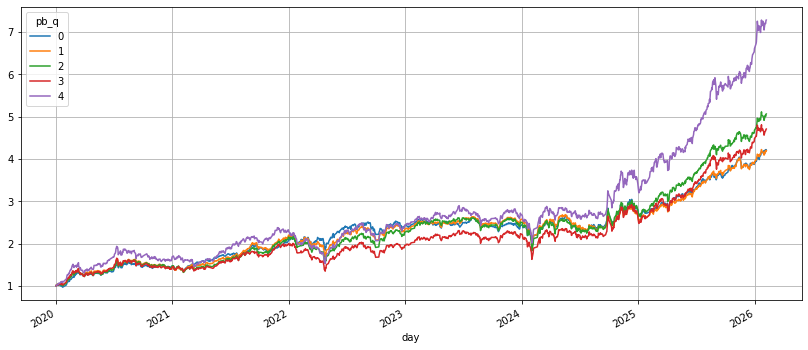

In [21]:
df_all['f_ret_co'] = (daily_data['open'].shift(-2)/ daily_data['close'].shift(-1)).stack()
df_all['f_ret_oo'] = (daily_data['open'].shift(-2)/ daily_data['open'].shift(-1)).stack()

df_all['pb_q'] = df_all.groupby('day')['pb'].transform(lambda x:pd.qcut(x,5,labels=range(5)))
# print(df_all.groupby(['day','pb_q'])['f_ret'].mean())
print(df_all.groupby(['day','pb_q'])['f_ret'].mean().unstack().cumprod().dropna())
print(df_all.groupby(['day','pb_q'])['f_ret_co'].mean().unstack().cumprod().dropna())
print(df_all.groupby(['day','pb_q'])['f_ret_oo'].mean().unstack().cumprod().dropna())
(df_all.groupby(['day','pb_q'])['f_ret'].mean().unstack().cumprod().dropna().plot(grid=True,figsize=(14,6)))

# print(df_all['pb_q'])

In [33]:
print('整体来看日内收益远超隔夜收益')
print('接下来分析什么场景下隔夜收益为正')
def safe_qcut(x):
    if x.nunique() < 5:
        return pd.Series(np.nan, index=x.index)
    return pd.qcut(x, 5, labels=False, duplicates='drop')
print(df_all[['f_ret','f_ret_co','f_ret_oo']])
df_all['f_ret_q'] = df_all[['f_ret','f_ret_co','f_ret_oo']].dropna().groupby('day')['f_ret'].transform(safe_qcut)
print(df_all.groupby(['day','f_ret_q'])['f_ret_co'].mean().unstack().cumprod())
print('使用cut来分割')
# df_all['f_ret_q'] = df_all[['f_ret','f_ret_co','f_ret_oo']].dropna().groupby('day')['f_ret'].transform(lambda x:pd.cut(x,bins=))
df_all['f_ret_cut'] = pd.cut(
    df_all['f_ret'],
    bins=5,
    labels=False
)
print(df_all.groupby(['day','f_ret_cut'])['f_ret_co'].mean().unstack().cumprod())

整体来看日内收益远超隔夜收益
接下来分析什么场景下隔夜收益为正
                         f_ret  f_ret_co  f_ret_oo
day        sec                                    
2020-01-02 000006.SZ  1.014815  0.994526  1.009259
           000011.SZ  0.997897  0.990516  0.988433
           000016.SZ  0.997763  0.995516  0.993289
           000019.SZ  1.025848  0.993701  1.019386
           000025.SZ  0.996232  0.992908  0.989166
...                        ...       ...       ...
2026-02-10 688122.SH       NaN       NaN       NaN
           688139.SH       NaN       NaN       NaN
           688188.SH       NaN       NaN       NaN
           688366.SH       NaN       NaN       NaN
           688388.SH       NaN       NaN       NaN

[1464696 rows x 3 columns]
f_ret_q          0.0       1.0       2.0       3.0       4.0
day                                                         
2020-01-02  0.991985  0.994546  0.994879  0.997755  1.000332
2020-01-03  0.993874  0.996931  0.995676  0.998709  1.001521
2020-01-06  0.990233  0.995531  0

In [40]:
print(df_all.groupby('day')[['f_ret','f_ret_co']].apply(lambda x:x.corr().iloc[0,1]))
print(df_all.groupby('day')[['f_ret','f_ret_co']].apply(lambda x:x.corr().iloc[0,1]).describe())
df_all['f_ret_cut'] = pd.cut(
    df_all['f_ret'],
    bins=[0.8, 0.95,0.99, 1, 1.01, 1.05, 1.095,2]
)
print(df_all.groupby(['day','f_ret_cut'])['f_ret_co'].mean().unstack().cumprod())



day
2020-01-02    0.180779
2020-01-03    0.024202
2020-01-06   -0.031681
2020-01-07   -0.221448
2020-01-08    0.266768
                ...   
2026-02-03    0.095728
2026-02-04    0.102452
2026-02-05    0.063502
2026-02-06         NaN
2026-02-10         NaN
Length: 1481, dtype: float64
count    1479.000000
mean        0.027457
std         0.119822
min        -0.560368
25%        -0.048430
50%         0.027114
75%         0.101532
max         0.805965
dtype: float64
f_ret_cut   (0.8, 0.95]  (0.95, 0.99]  (0.99, 1.0]  (1.0, 1.01]  (1.01, 1.05]  \
day                                                                             
2020-01-02     0.983212      0.992640     0.993791     0.995569      0.999367   
2020-01-03          NaN      0.994190     0.997224     0.996634      1.000012   
2020-01-06     0.972363      0.989139     0.996753     0.993260      0.994618   
2020-01-07     0.982750      0.998610     1.003654     1.003333      0.997163   
2020-01-08     0.970527      0.999260     1.0

In [ ]:
daily_basic_data = get_all_data(
    sec_list=zz1000_list,
    data_type='daily_basic',
    start='20200101',
    end='20261212'
)
print(daily_basic_data.keys())

**返回结果说明**：
- `index`: 日期（datetime格式）
- `columns`: 股票代码（如000001.SZ）
- `values`: 因子值

---

## 2. 收益率计算

因子分析的核心是计算未来收益率，然后计算因子与收益率之间的相关性（IC）。

In [ ]:
def compute_returns(prices: pd.DataFrame, forward_periods: int = 1) -> pd.DataFrame:
    """
    计算未来收益率

    Args:
        prices: 价格DataFrame
        forward_periods: 未来天数（默认1天）

    Returns:
        未来收益率DataFrame
    """
    returns = prices.pct_change().shift(-forward_periods)
    return returns.iloc[:-forward_periods]

# 计算未来1日收益率
returns_df = compute_returns(close_df)
print(f"收益率数据形状: {returns_df.shape}")
print(f"\n收益率统计:")
print(returns_df.stack().describe())

收益率数据形状: (242, 5500)

收益率统计:
count    1.315685e+06
mean     1.409965e-03
std      3.070254e-02
min     -8.932584e-01
25%     -1.232966e-02
50%      0.000000e+00
75%      1.286174e-02
max      5.784098e-01
dtype: float64


**关键概念**：
- `shift(-1)`: 因子值在t日，收益率是t+1日（未来收益率）
- `stack()`: 将宽表转为长表，便于统计分析

---

## 3. 涨停与成交不足过滤

### 3.1 加载过滤所需数据

In [ ]:
# 加载涨跌幅和成交金额
pct_chg_df = get_local_data(
    start='20250101', end='20251231',
    filed='pct_chg', data_type='daily'
)

amount_df = get_local_data(
    start='20250101', end='20251231',
    filed='amount', data_type='daily'
)

print(f"涨跌幅数据形状: {pct_chg_df.shape}")
print(f"成交金额数据形状: {amount_df.shape}")

# 注意：amount单位是【万元】
print(f"\n成交金额示例（万元）:")
print(amount_df.head())

涨跌幅数据形状: (243, 5500)
成交金额数据形状: (243, 5500)

成交金额示例（万元）:
ts_code       000001.SZ   000002.SZ   000004.SZ   000006.SZ  000007.SZ  \
date                                                                     
2025-01-02  2102923.078  854487.563  167987.024  225252.942  48456.355   
2025-01-03  1320520.978  795154.845  164927.377  275530.027  53622.184   
2025-01-06  1234305.778  591154.773  106111.266  216461.997  25114.735   
2025-01-07   858329.049  504087.513  110966.824  160237.518  21530.880   
2025-01-08  1223598.997  632775.676  132231.151  253004.650  26524.725   

ts_code      000008.SZ   000009.SZ   000010.SZ  000011.SZ  000012.SZ  ...  \
date                                                                  ...   
2025-01-02  316812.796  215305.581   95665.836  36956.749  85557.805  ...   
2025-01-03  319412.025  126688.166   75658.571  40593.401  82624.045  ...   
2025-01-06  236957.732   94111.507   70149.192  24182.482  65223.298  ...   
2025-01-07  186369.920   88586.233  1411

### 3.2 定义过滤条件

过滤逻辑：
- **涨停过滤**: `pct_chg >= 9.5%`（A股涨停板）
- **成交不足过滤**: `amount < 100万`（单位已转换，100万/1万=100万）

In [ ]:
# 定义阈值
LIMIT_UP_THRESHOLD = 9.5  # 涨停阈值（%）
MIN_AMOUNT = 100  # 最小成交金额（万），即100万

# 计算过滤掩码
limit_up_mask = pct_chg_df >= LIMIT_UP_THRESHOLD
low_amount_mask = amount_df < MIN_AMOUNT
filter_mask = limit_up_mask | low_amount_mask

print(f"涨停股票数: {limit_up_mask.sum().sum()}")
print(f"成交不足股票数: {low_amount_mask.sum().sum()}")
print(f"过滤总数: {filter_mask.sum().sum()}")
print(f"过滤比例: {filter_mask.sum().sum() / pct_chg_df.size * 100:.2f}%")

涨停股票数: 22226
成交不足股票数: 5
过滤总数: 22231
过滤比例: 1.66%


### 3.3 应用过滤

将涨停和成交不足股票的因子值设为NaN：

In [ ]:
# 复制因子数据并应用过滤
factor_filtered = close_df.copy()
factor_filtered[filter_mask] = np.nan

print(f"原始数据量: {close_df.size}")
print(f"过滤后数据量: {factor_filtered.size - factor_filtered.isna().sum().sum()}")
print(f"保留比例: {(~factor_filtered.isna()).sum().sum() / close_df.size * 100:.2f}%")

原始数据量: 1336500
过滤后数据量: 1291667
保留比例: 96.65%


---

## 4. IC（信息系数）分析

### 4.1 IC计算原理

IC（Information Coefficient）衡量因子预测能力，计算方式：
- **Pearson IC**: 因子值与收益率的皮尔逊相关系数
- **Spearman IC**: 因子值与收益率的斯皮尔曼相关系数（秩相关，更稳健）

本分析使用**Spearman IC**。

In [ ]:
def compute_ic(
    factor_df: pd.DataFrame,
    returns_df: pd.DataFrame,
    method: str = 'spearman'
) -> Tuple[np.ndarray, Dict]:
    """
    计算信息系数（IC）

    Args:
        factor_df: 因子值DataFrame
        returns_df: 收益率DataFrame
        method: 'spearman' or 'pearson'

    Returns:
        ic_series: 每日IC值
        ic_stats: IC统计信息
    """
    # 对齐日期
    common_dates = factor_df.index.intersection(returns_df.index)
    factor_aligned = factor_df.loc[common_dates]
    returns_aligned = returns_df.loc[common_dates]

    # 找到共同的股票
    common_stocks = factor_aligned.columns.intersection(returns_aligned.columns)
    factor_aligned = factor_aligned[common_stocks]
    returns_aligned = returns_aligned[common_stocks]

    ic_series = []

    for date in common_dates:
        factor_vals = factor_aligned.loc[date].values
        return_vals = returns_aligned.loc[date].values

        # 去除NaN
        mask = ~(np.isnan(factor_vals) | np.isnan(return_vals))
        if mask.sum() < 10:
            continue

        factor_vals = factor_vals[mask]
        return_vals = return_vals[mask]

        if method == 'spearman':
            ic, _ = stats.spearmanr(factor_vals, return_vals)
        else:
            ic, _ = stats.pearsonr(factor_vals, return_vals)

        if not np.isnan(ic):
            ic_series.append(ic)

    ic_series = np.array(ic_series)

    if len(ic_series) > 0:
        ic_stats = {
            'ic_mean': float(np.mean(ic_series)),
            'ic_std': float(np.std(ic_series)),
            'ic_ir': float(np.mean(ic_series) / np.std(ic_series)) if np.std(ic_series) > 0 else 0,
            'ic_positive_ratio': float((ic_series > 0).mean()),
            'ic_t_stat': float(np.mean(ic_series) / (np.std(ic_series) / np.sqrt(len(ic_series)))) if np.std(ic_series) > 0 else 0,
            'ic_count': len(ic_series)
        }
    else:
        ic_stats = {}

    return ic_series, ic_stats

# 计算IC
ic_series, ic_stats = compute_ic(factor_filtered, returns_df)

print("="*50)
print("IC分析结果")
print("="*50)
print(f"IC均值: {ic_stats.get('ic_mean', 'N/A'):.4f}")
print(f"IC标准差: {ic_stats.get('ic_std', 'N/A'):.4f}")
print(f"IC IR（信息比率）: {ic_stats.get('ic_ir', 'N/A'):.4f}")
print(f"正IC占比: {ic_stats.get('ic_positive_ratio', 'N/A')*100:.2f}%")
print(f"IC T统计量: {ic_stats.get('ic_t_stat', 'N/A'):.4f}")
print(f"交易日数: {ic_stats.get('ic_count', 'N/A')}")

IC分析结果
IC均值: -0.0161
IC标准差: 0.1714
IC IR（信息比率）: -0.0942
正IC占比: 47.93%
IC T统计量: -1.4659
交易日数: 242


### 4.2 IC解读

| IC IR范围 | 因子评级 | 说明 |
|----------|---------|------|
| IR > 0.5 | 优秀 | 因子预测能力强 |
| 0.3 < IR <= 0.5 | 良好 | 因子有稳定预测能力 |
| 0.1 < IR <= 0.3 | 一般 | 因子有一定预测能力 |
| 0 <= IR <= 0.1 | 中性 | 因子预测能力弱 |
| IR < 0 | 无效/反向 | 因子无效或反向 |

---

## 5. 分层收益回测

### 5.1 分层方法

将股票按因子值分为5组（Q1-Q5），Q1为因子值最低组，Q5为最高组。

In [ ]:
def compute_quantile_returns(
    factor_df: pd.DataFrame,
    returns_df: pd.DataFrame,
    quantiles: int = 5
) -> Dict:
    """
    计算分层组合收益
    """
    common_dates = factor_df.index.intersection(returns_df.index)
    factor_aligned = factor_df.loc[common_dates]
    returns_aligned = returns_df.loc[common_dates]

    common_stocks = factor_aligned.columns.intersection(returns_aligned.columns)
    factor_aligned = factor_aligned[common_stocks]
    returns_aligned = returns_aligned[common_stocks]

    results = {}

    for date in common_dates:
        factor_vals = factor_aligned.loc[date].values
        return_vals = returns_aligned.loc[date].values

        mask = ~(np.isnan(factor_vals) | np.isnan(return_vals))
        if mask.sum() < quantiles * 2:
            continue

        valid_factor = factor_vals[mask]
        valid_returns = return_vals[mask]

        try:
            quantile_bounds = np.nanpercentile(valid_factor, np.linspace(0, 100, quantiles + 1))
            quantile_bounds[0] = -np.inf
            quantile_bounds[-1] = np.inf
        except:
            continue

        for i in range(quantiles):
            lower = quantile_bounds[i]
            upper = quantile_bounds[i + 1]
            group_mask = (valid_factor >= lower) & (valid_factor < upper)

            if group_mask.sum() > 0:
                group_key = f'Q{i + 1}'
                if group_key not in results:
                    results[group_key] = []
                results[group_key].append(valid_returns[group_mask].mean())

    for key in results:
        returns_list = results[key]
        results[key] = {
            'mean_return': float(np.mean(returns_list)),
            'std': float(np.std(returns_list)),
            'count': len(returns_list)
        }

    if 'Q1' in results and f'Q{quantiles}' in results:
        top = results[f'Q{quantiles}']['mean_return']
        bottom = results['Q1']['mean_return']
        results['Long_Short'] = {
            'mean_return': float(top - bottom),
            'win_rate': float((top > bottom).mean()) if isinstance(top, pd.Series) else (top > bottom)
        }

    return results

# 计算分层收益
quantile_returns = compute_quantile_returns(factor_filtered, returns_df)

print("="*50)
print("分层收益分析")
print("="*50)
for key in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Long_Short']:
    if key in quantile_returns:
        r = quantile_returns[key]
        print(f"{key}",r)
        # print(f"{key}: 均值={r['mean_return']*100:.4f}%, 标准差={r['std']*100:.4f}%")

分层收益分析
Q1 {'mean_return': 0.0010885302281420496, 'std': 0.012564672350659707, 'count': 242}
Q2 {'mean_return': 0.0011431560961392435, 'std': 0.012662613908321593, 'count': 242}
Q3 {'mean_return': 0.0013752984349282831, 'std': 0.014202872623713855, 'count': 242}
Q4 {'mean_return': 0.001372583451550295, 'std': 0.015388011132571879, 'count': 242}
Q5 {'mean_return': 0.0011683955734179611, 'std': 0.016423378643742232, 'count': 242}
Long_Short {'mean_return': 7.986534527591152e-05, 'win_rate': True}


### 5.2 分层收益解读

理想情况下：
- Q1（低因子值）收益最低
- Q5（高因子值）收益最高
- Long_Short（多空组合）有显著正收益

---

## 6. 完整因子分析函数

In [ ]:
def analyze_single_factor(
    factor_name: str,
    data_type: str,
    field: str,
    stocks: List[str],
    start_date: str,
    end_date: str,
    limit_up_threshold: float = 9.5,
    min_amount: float = 100
) -> Dict:
    """
    完整因子分析流程
    """
    print(f"分析因子: {factor_name}")

    # 1. 加载因子数据
    factor_df = get_local_data(
        sec_list=stocks, start=start_date, end=end_date,
        filed=field, data_type=data_type
    )

    if factor_df.empty:
        return {'error': '数据为空'}

    # 2. 计算收益率
    returns_df = compute_returns(factor_df)

    # 3. 对齐日期
    common_dates = factor_df.index.intersection(returns_df.index)
    factor_df = factor_df.loc[common_dates]
    returns_df = returns_df.loc[common_dates]

    # 4. 加载过滤数据
    try:
        pct_chg_df = get_local_data(
            sec_list=stocks, start=start_date, end=end_date,
            filed='pct_chg', data_type='daily'
        )
        amount_df = get_local_data(
            sec_list=stocks, start=start_date, end=end_date,
            filed='amount', data_type='daily'
        )

        pct_chg_df = pct_chg_df.loc[common_dates]
        amount_df = amount_df.loc[common_dates]

        common_stocks = factor_df.columns.intersection(
            pct_chg_df.columns
        ).intersection(amount_df.columns)
        factor_df = factor_df[common_stocks]
        pct_chg_df = pct_chg_df[common_stocks]
        amount_df = amount_df[common_stocks]

        limit_up_mask = pct_chg_df >= limit_up_threshold
        low_amount_mask = amount_df < min_amount
        filter_mask = limit_up_mask | low_amount_mask

        factor_filtered = factor_df.copy()
        factor_filtered[filter_mask] = np.nan

        total = factor_df.size
        filtered = filter_mask.sum().sum()
        print(f"  过滤: {filtered}/{total} ({filtered/total*100:.1f}%)")

    except Exception as e:
        print(f"  警告: 过滤失败 ({e})")
        factor_filtered = factor_df

    # 5. 计算IC
    ic_series, ic_stats = compute_ic(factor_filtered, returns_df)

    # 6. 计算分层收益
    quantile_returns = compute_quantile_returns(factor_filtered, returns_df)

    result = {
        'factor': factor_name,
        'data_type': data_type,
        'field': field,
        'start_date': start_date,
        'end_date': end_date,
        'stock_count': len(factor_df.columns),
        'date_count': len(factor_df),
        'ic_stats': ic_stats,
        'quantile_returns': quantile_returns,
        'ic_series': ic_series.tolist() if len(ic_series) > 0 else []
    }

    print(f"  完成: IC均值={ic_stats.get('ic_mean', 'N/A'):.4f}")

    return result

---

## 7. 批量因子分析示例

In [ ]:
# 定义要分析的因子
factors_to_analyze = [
    ('volume_ratio', 'daily_basic', 'volume_ratio'),
    ('turnover_rate', 'daily_basic', 'turnover_rate'),
    ('close', 'daily', 'close'),
]

# 示例股票列表
stocks = ['000001.SZ', '000002.SZ', '000004.SZ', '000005.SZ', '000006.SZ',
          '000007.SZ', '000008.SZ', '000009.SZ', '000010.SZ', '000011.SZ']

# 执行分析
results = []
for name, dtype, field in factors_to_analyze:
    result = analyze_single_factor(
        factor_name=name, data_type=dtype, field=field,
        stocks=stocks, start_date='20250101', end_date='20250131'
    )
    if 'error' not in result:
        results.append(result)

print("\n" + "="*50)
print("因子对比")
print("="*50)
for r in sorted(results, key=lambda x: x['ic_stats'].get('ic_ir', 0), reverse=True):
    print(f"{r['factor']}: IC IR={r['ic_stats'].get('ic_ir', 0):.4f}, IC均值={r['ic_stats'].get('ic_mean', 0):.4f}")

分析因子: volume_ratio
  过滤: 2/153 (1.3%)


ValueError: Unknown format code 'f' for object of type 'str'

---

## 8. 可视化

In [ ]:
import matplotlib.pyplot as plt

if len(results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # IC序列图
    ax1 = axes[0]
    for r in results[:2]:
        ic_series = np.array(r['ic_series'])
        if len(ic_series) > 0:
            ax1.plot(ic_series, alpha=0.7, label=r['factor'])
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_title("IC时间序列")
    ax1.set_xlabel("交易日")
    ax1.set_ylabel("IC值")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 分层收益图
    ax2 = axes[1]
    x = np.arange(5)
    width = 0.35
    for i, r in enumerate(results[:2]):
        means = [r['quantile_returns'].get(f'Q{j+1}', {}).get('mean_return', 0) * 100 for j in range(5)]
        ax2.bar(x + i * width, means, width, label=r['factor'])

    ax2.set_xlabel("分位数组")
    ax2.set_ylabel("平均日收益率 (%)")
    ax2.set_title("分层收益对比")
    ax2.set_xticks(x + width / 2)
    ax2.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='r', linestyle='--')

    plt.tight_layout()
    plt.savefig('factor_analysis.png', dpi=150)
    plt.show()
    print("图表已保存到 factor_analysis.png")

---

## 9. 总结

### 关键步骤

1. **数据加载**: `get_local_data()` 从parquet文件加载
2. **收益率计算**: `prices.pct_change().shift(-1)` 计算未来收益
3. **过滤处理**: 涨停(>=9.5%) + 成交不足(<100万)
4. **IC计算**: Spearman秩相关系数
5. **分层回测**: Q1-Q5分组收益

### 注意事项

- **amount单位**: Tushare的amount是**万元**，100万=100
- **NaN处理**: 过滤时将无效数据设为NaN
- **日期对齐**: 确保因子、收益、过滤数据日期一致

In [ ]:
print("\n" + "="*50)
print("Notebook执行完成！")
print("="*50)